 ╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 7. Neural Network Improvements**
# Section 8. Optimizer (2) RMSProp and Adam

### _Objective_
1. RMSProp Optimizer에 대해 배워보겠습니다. <br>
2. 가장 많이 쓰이는 Adam Optimizer에 대해 배워보겠습니다. <br>
  
╚═════════════════════════════════════════╝

In [78]:
%matplotlib inline
import numpy as np
import pandas as pd

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(30)
tf.random.set_random_seed(30)

<br><br>

# \[ 1. RMSProp와 Adam Optimizer이란? \]

----
----

> *RMSProp 알고리즘도 모멘텀 알고리즘과 다른 방식으로 Gradient Descent 알고리즘에
지수이동평균 수식을 포함한 수식입니다.*<br>
> *Adam 알고리즘은 RMSProp 알고리즘과 Momentum 알고리즘을 결합한 수식입니다.*<br>

<br>

## 1. RMSProp Optimizer 수식
---
$$
G_{t+1} = \beta G_{t} + (\triangledown_{W}J(W_t))^2\\
W_{t+1} = W_{t} - \frac{\alpha}{\sqrt{G_{t+1}+\epsilon}}\cdot \triangledown_{W}J(W_t)
$$
* RMSProp은 이전까지 변화해왔던 크기만큼을 나누어줌으로써, 많이 변화한 weight는 세밀하게 조정하도록, 적게 변화한 weight은 크게 조정하도록 설계되었습니다. <br>
* 학습 Step에 따라, 변화하는 크기를 조정하기 때문에 적응적 학습률(Adaptive Learning)이라고도 불립니다. <br>


<br>

## 2. ADAM Optimizer 수식
---
$$
m_{t+1} = \beta_1 m_{t} + (1-\beta_1)\triangledown_{w}J(w)\\
v_{t+1} = \beta_2 v_{t} + (1-\beta_2)(\triangledown_{w}J(w))^2\\
\hat m_{t+1} = \frac{m_{t+1}}{1-\beta^t_1}\\
\hat v_{t+1} = \frac{v_{t+1}}{1-\beta^t_2}\\
w_{t+1} = w_{t} - \frac{\alpha}{\sqrt{\hat v_t + \epsilon}}\hat m_{t+1}
$$
* Adam 알고리즘은 Momentum알고리즘과 RMSProp 알고리즘을 합쳤습니다.<br>
* 이때 지수보정 수식은 지수 편향식과 $(1-\beta)$ 가중치를 모두 포함한 수식입니다.<br>
* 보통 $\beta_1$로는 0.9, $\beta_2$로는 0.999, $\epsilon$ 으로는 $10^{-8}$ 정도의 값을 사용합니다.

## 3. Optimizer의 계보
---
출처 : 하용호, 자습해도 모르겠던 딥러닝, 머리속에 인스톨 시켜드립니다

![Imgur](https://i.imgur.com/gjdZ0S5.jpg)

<br><br>

# \[ 2. RMSProp와 Adam Optimizer 시각화하기 \]

----

----


## \[ Optional. Beale Function Visualization \]
---
> 최적화 함수(Optimizer)를 평가하기 위해, 보통 Beale Function과 같은 test function을 많이 이용합니다.<br>

$$
f(x,y) = (1.5 - x + xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2
$$

In [79]:
def beale(x, y):
    return ((1.5 - x + x * y) ** 2 + 
            (2.25 - x + x * y ** 2) ** 2 + 
            (2.625 - x + x * y ** 3) ** 2)

In [80]:
def generate_beale_plot():
    # Beale function을 공간으로 치환한 것을 
    xmin, xmax, xstep = -4.5, 4.5, .2
    ymin, ymax, ystep = -4.5, 4.5, .2

    xs_ = np.arange(xmin, xmax, xstep)
    ys_ = np.arange(ymin, ymax, ystep)

    x, y = np.meshgrid(xs_, ys_)
    z = beale(x, y)

    minima = np.array([3., .5])
    minima_ = minima.reshape(-1, 1)
    z_minima = beale(*minima)
    # z_minima = minima.reshape(-1, 1)

    plt.figure(figsize=(8, 5))
    ax = plt.axes(projection='3d', elev=50, azim=-50)

    ax.plot(*minima_, z_minima, 'r*', markersize=10)
    ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1,
                    edgecolor='None', alpha=0.3, cmap=plt.cm.jet)

    ax.view_init(30, 10)
    ax.set_title("Beale Function Visualization")
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    return ax

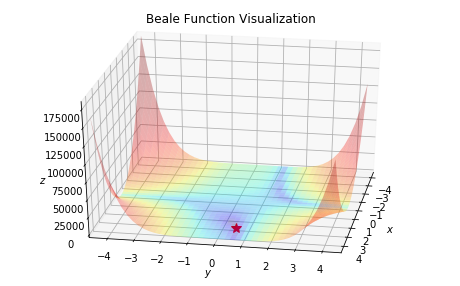

In [81]:
ax = generate_beale_plot()

## 1. RMSProp Optimizer 시각화하기
---

In [82]:
def rmsprop_graph(start_x, start_y, func, lr, decay=0.999):
    graph = tf.Graph()
    with graph.as_default():
        x = tf.Variable(initial_value=tf.constant(start_x), name='x')
        y = tf.Variable(initial_value=tf.constant(start_y), name='y')

        # Get Gradient x,y with tf_f
        z = func(x, y)
        z = tf.identity(z, name='z')
        train_op = (tf.train
                    .RMSPropOptimizer(lr, decay=decay)
                    .minimize(z,name='train_op'))
    return graph

In [83]:
def trace(graph, max_iter):
    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())

        x = graph.get_tensor_by_name('x:0')
        y = graph.get_tensor_by_name('y:0')
        z = graph.get_tensor_by_name('z:0')
        train_op = graph.get_collection(tf.GraphKeys.TRAIN_OP)[0]

        xs, ys, zs = [], [], []
        for i in range(max_iter):
            x_, y_, z_ = sess.run([x, y, z])

            xs.append(x_)
            ys.append(y_)
            zs.append(z_)

            sess.run(train_op)
    return xs, ys, zs

### (1) decay가 0.9일 때 시각화

In [84]:
start_x, start_y = -2.5, -4.

decay = 0.9
learning_rate = 0.05
max_iter = 10000

graph = rmsprop_graph(start_x,start_y, beale, learning_rate,decay)

rmsp_xs, rmsp_ys, rmsp_zs = trace(graph, max_iter)

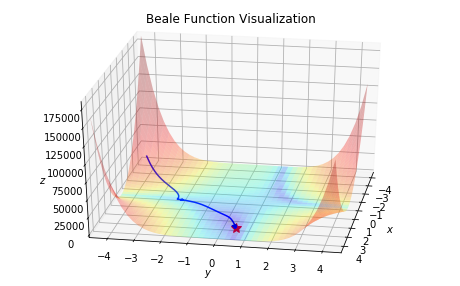

In [90]:
ax = generate_beale_plot()
ax.plot(rmsp_xs, rmsp_ys, rmsp_zs, 
        label='RMSP(decay={})'.format(decay), 
        color='b')
plt.show()

### (2) decay에 따른 변화

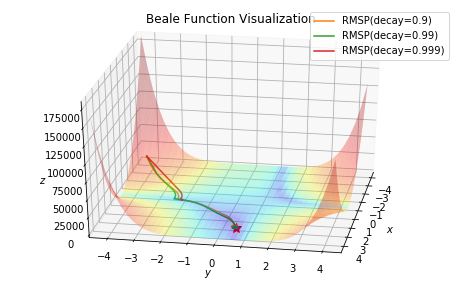

In [51]:
ax = generate_beale_plot()

for decay in [0.9,0.99,0.999]:
    max_iter = 2000

    graph = rmsprop_graph(start_x,start_y, beale, learning_rate, decay)
    rmsp_xs, rmsp_ys, rmsp_zs = trace(graph, max_iter)
    
    ax.plot(rmsp_xs, rmsp_ys, rmsp_zs, 
            label='RMSP(decay={})'.format(decay))
plt.legend()
plt.show()

## 2. ADAM Optimizer 시각화하기
---

In [86]:
def adam_graph(start_x, start_y, func, lr):
    graph = tf.Graph()
    with graph.as_default():
        x = tf.Variable(initial_value=tf.constant(start_x), name='x')
        y = tf.Variable(initial_value=tf.constant(start_y), name='y')

        # Get Gradient x,y with tf_f
        z = func(x, y)
        z = tf.identity(z, name='z')
        train_op = (tf.train
                    .AdamOptimizer(lr)
                    .minimize(z,name='train_op'))
    return graph

### (1)  Adam optimizer 시각화

In [88]:
start_x, start_y = -2.5, -4.

learning_rate = 0.5
max_iter = 10000

graph = adam_graph(start_x,start_y, beale, learning_rate)

adam_xs, adam_ys, adam_zs = trace(graph, max_iter)

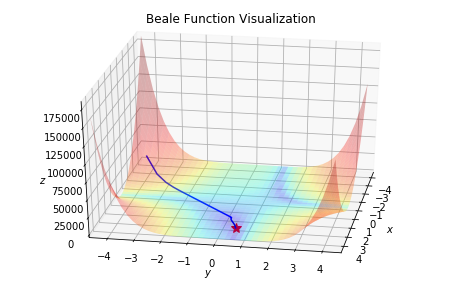

In [89]:
ax = generate_beale_plot()
ax.plot(adam_xs, adam_ys, adam_zs,
        label='adam', 
        color='b')
plt.show()

### (2) Learning Rate에 따른 변화

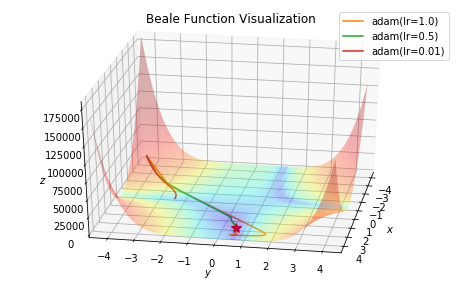

In [76]:
ax = generate_beale_plot()
for lr in [1.,0.5,0.01]:
    graph = adam_graph(start_x,start_y,beale,lr)
    momentum_xs, momentum_ys, momentum_zs = trace(graph, max_iter)
    
    ax.plot(momentum_xs, momentum_ys, momentum_zs, 
            label='adam(lr={})'.format(lr))
plt.legend()
plt.show()

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/04/05

---